In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import time

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

TRAFFIC_DIRECTION = 'received'


np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
import requests
import json

# Fetch data from netdata
vim_endpoint = "vimdemo1.cs.upb.de"
chart_id = "cgroup_qemu_qemu_127_instance_0000007f.net_tap0c32c278_4e"
# 7 days = 604800
avg_sec = 604800
group_time = 10
_c_name = chart_id.split(".")[1]

# http://vimdemo1.cs.upb.de:19999/api/v1/data?chart=cgroup_qemu_qemu_127_instance_0000007f.net_tap0c32c278_4e&gtime=60
_chart_avg_url = "http://{host}:19999/api/v1/data?chart={chart_id}&format=json&after=-{last_sec_avg}&gtime={gtime}"

r = requests.get(_chart_avg_url.format(host=vim_endpoint, chart_id=chart_id, 
                                           last_sec_avg=avg_sec, gtime=group_time), verify=False)

_instance_metrics = {}

if r.status_code == requests.codes.ok:
    _result_json = json.loads(r.text)
    if "net" in _c_name:
        if "packets" in _c_name:
            _instance_metrics["packets"] = _result_json
        else:
            _instance_metrics["net"] = _result_json
    else:
        _instance_metrics[_c_name] = _result_json

# _result_json


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

train = pd.DataFrame(_result_json['data'], columns=_result_json['labels'])

train = train.set_index("time")



traffic_training_complete = train
traffic_training_processed_complete = traffic_training_complete[[TRAFFIC_DIRECTION]]
traffic_training_scaled_complete = scaler.fit_transform(traffic_training_processed_complete)

train.head()

,received,sent
time,,
1586962410,37.335088,0.0
1586962400,25.399859,0.0
1586962390,7.536211,0.0
1586962380,10.704751,0.0
1586962370,7.575119,0.0


In [5]:
# plt.plot(time, sin, label='sine (with noise)');
# plt.legend();
traffic_training_scaled_complete

array([[0.14212488],
       [0.09372259],
       [0.0212781 ],
       ...,
       [0.04491   ],
       [0.05151623],
       [0.02366221]])

# Data Preprocessing

In [6]:
df = pd.DataFrame(traffic_training_scaled_complete, columns=[TRAFFIC_DIRECTION])
df.head(5)

df_original = pd.DataFrame(traffic_training_processed_complete, columns=[TRAFFIC_DIRECTION])
df_original.head(5)

,received
time,
1586962410,37.335088
1586962400,25.399859
1586962390,7.536211
1586962380,10.704751
1586962370,7.575119


In [7]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

train_original, test_original = df_original.iloc[0:train_size], df_original.iloc[train_size:len(df_original)]

test.head()

8952 2238


,received
8952,0.055884
8953,0.059732
8954,0.042650
8955,0.058845
8956,0.061637


In [27]:
# multi-step data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = np.array(train[TRAFFIC_DIRECTION])
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))



# define input sequence
raw_seq_test = np.array(test[TRAFFIC_DIRECTION])
X_test, y_test = split_sequence(raw_seq_test, n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X.shape)
print(X_test.shape)


(8948, 3, 1)
(2234, 3, 1)


# Modeling

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dense(1))

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = n_steps_out))

# model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Training

In [29]:
start_time = time.time()
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1
)

print("Time taken: ", time.time()-start_time)


Train on 8053 samples, validate on 895 samples
Epoch 1/5
8053/8053 [==============================] - 18s 2ms/sample - loss: 7.5896e-04 - val_loss: 6.0666e-04
Epoch 2/5
8053/8053 [==============================] - 7s 926us/sample - loss: 6.9684e-04 - val_loss: 5.9157e-04
Epoch 3/5
8053/8053 [==============================] - 7s 900us/sample - loss: 6.7893e-04 - val_loss: 5.7727e-04
Epoch 4/5
8053/8053 [==============================] - 7s 904us/sample - loss: 6.6580e-04 - val_loss: 5.6899e-04
Epoch 5/5
8053/8053 [==============================] - 7s 886us/sample - loss: 6.5340e-04 - val_loss: 6.2193e-04
Time taken:  48.08502674102783


## Evaluation

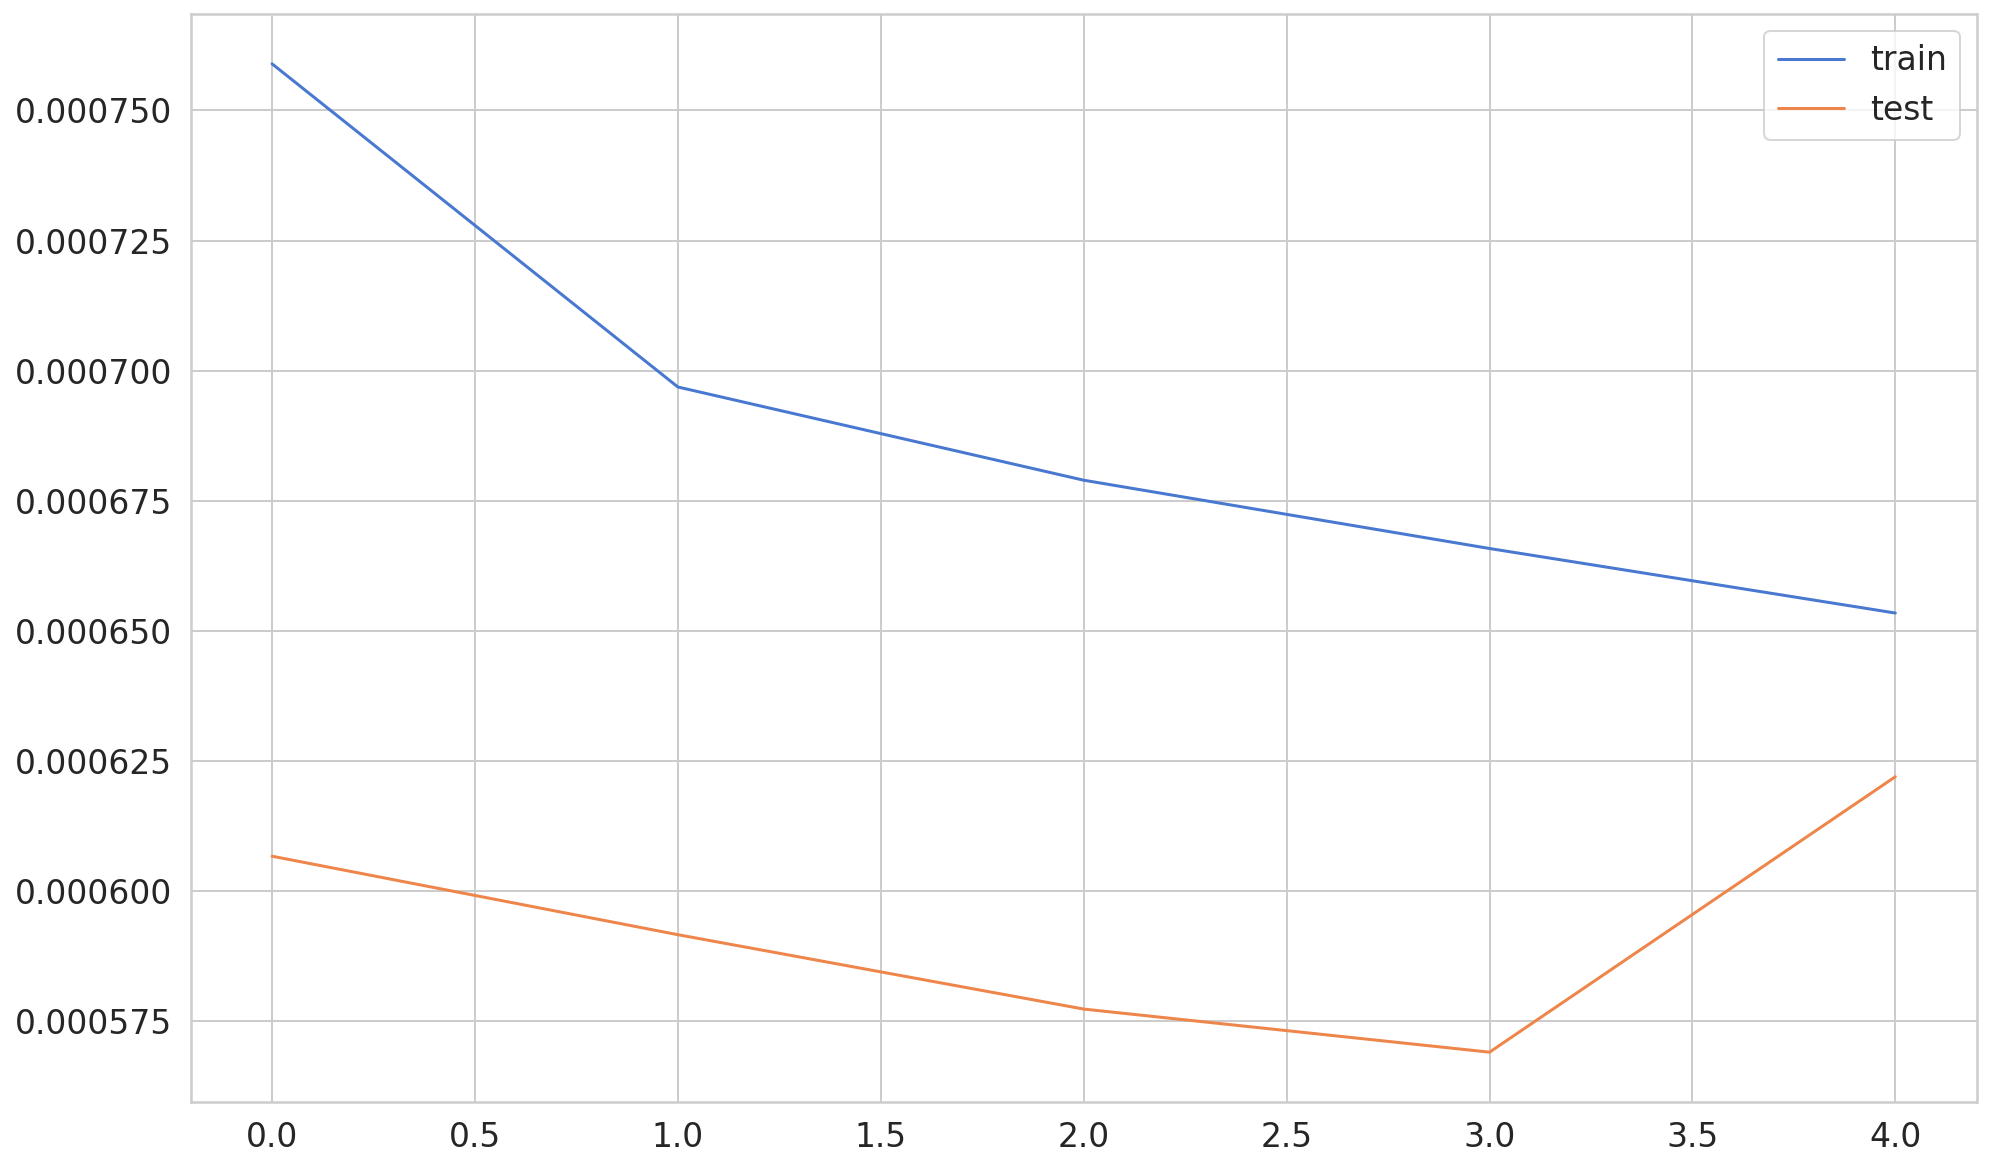

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [34]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

y_test = np.reshape(y_test, (y_test.shape[0], n_steps_out))
y_test.shape

y_train = np.reshape(y_train, (y_train.shape[0], n_steps_out))
y_train.shape

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [37]:
y_pred

array([[11.801475, 12.92323 ],
       [12.277319, 13.142251],
       [12.861091, 13.456897],
       ...,
       [14.567852, 14.230105],
       [25.846722, 20.922646],
       [19.341562, 18.156225]], dtype=float32)

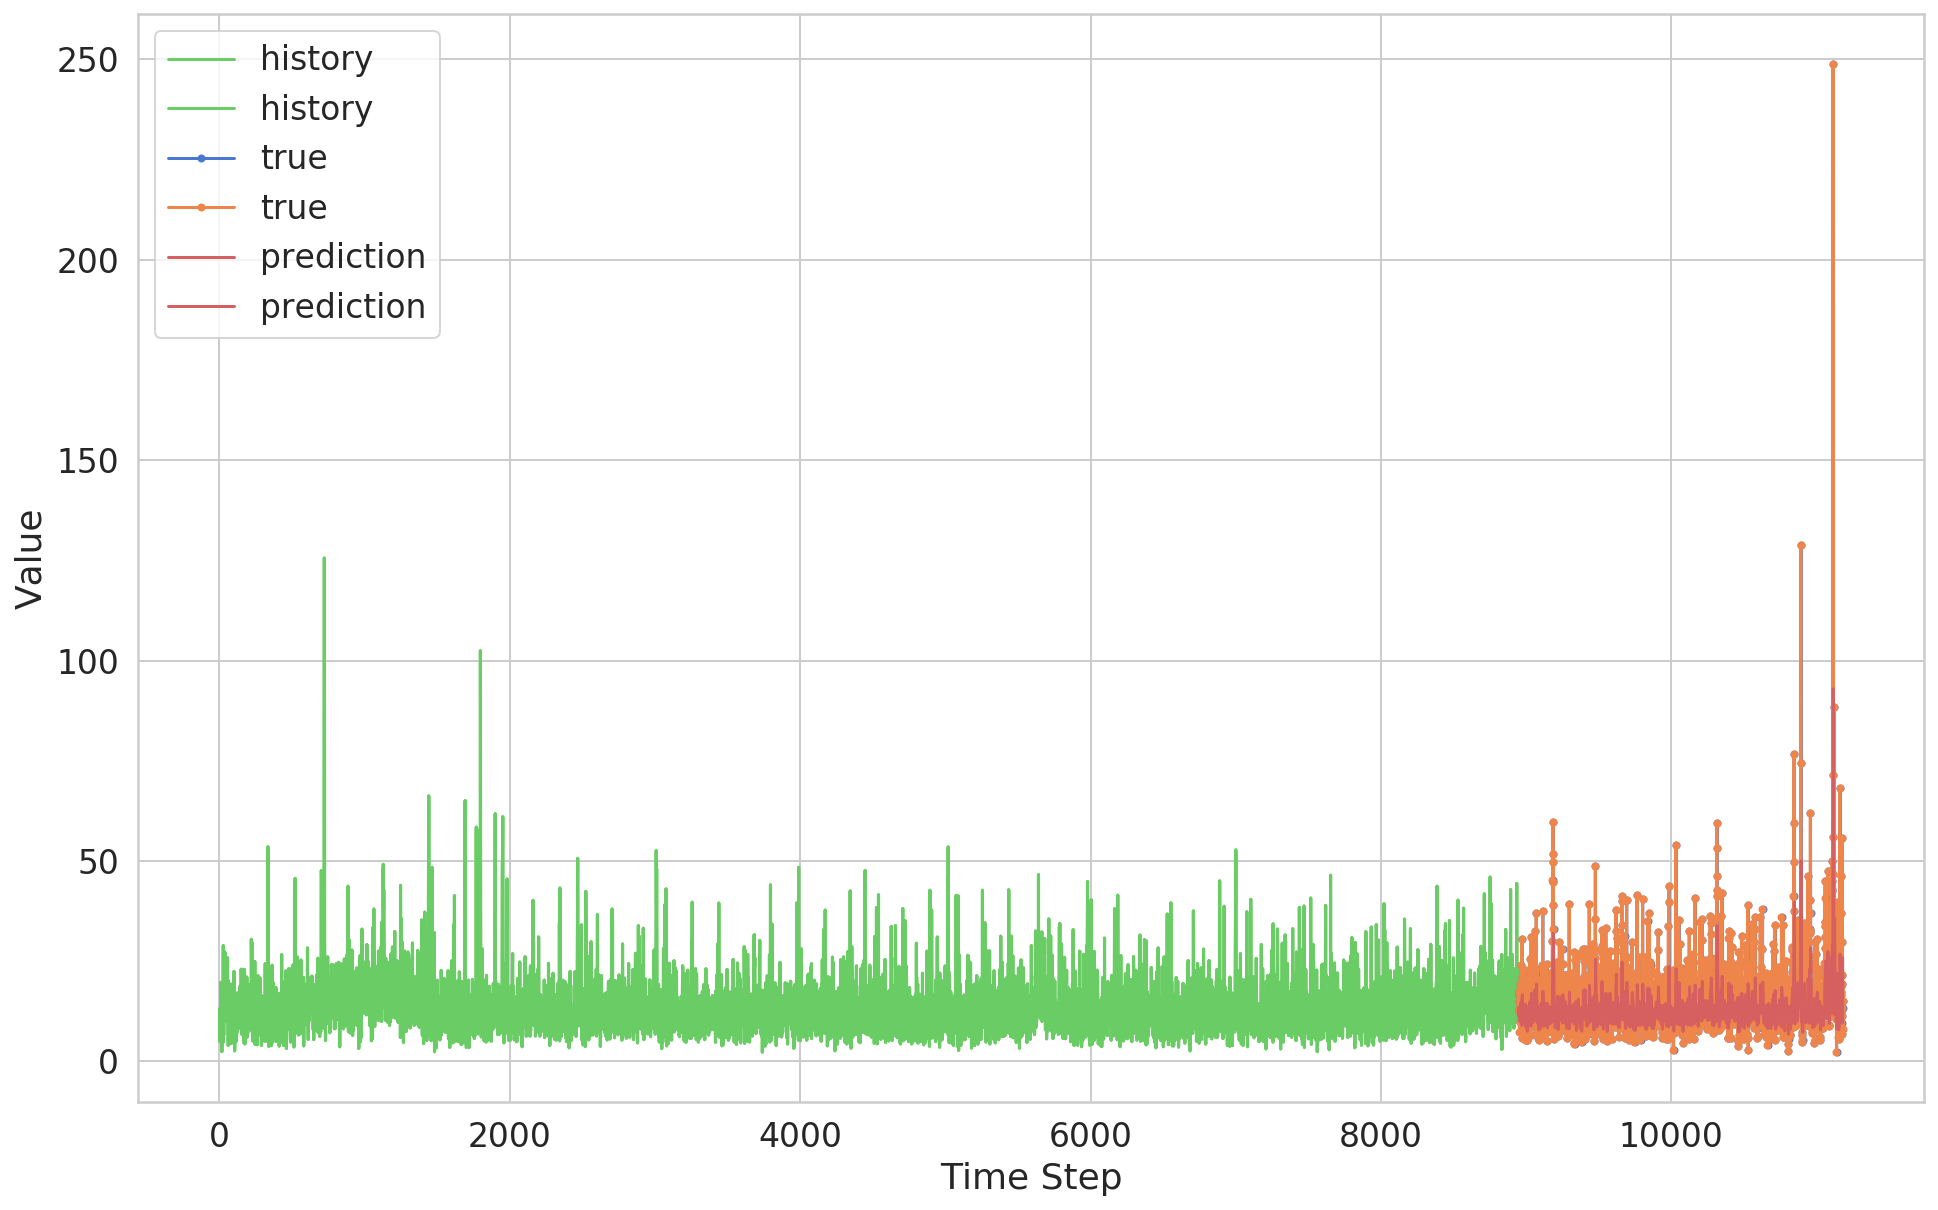

In [35]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

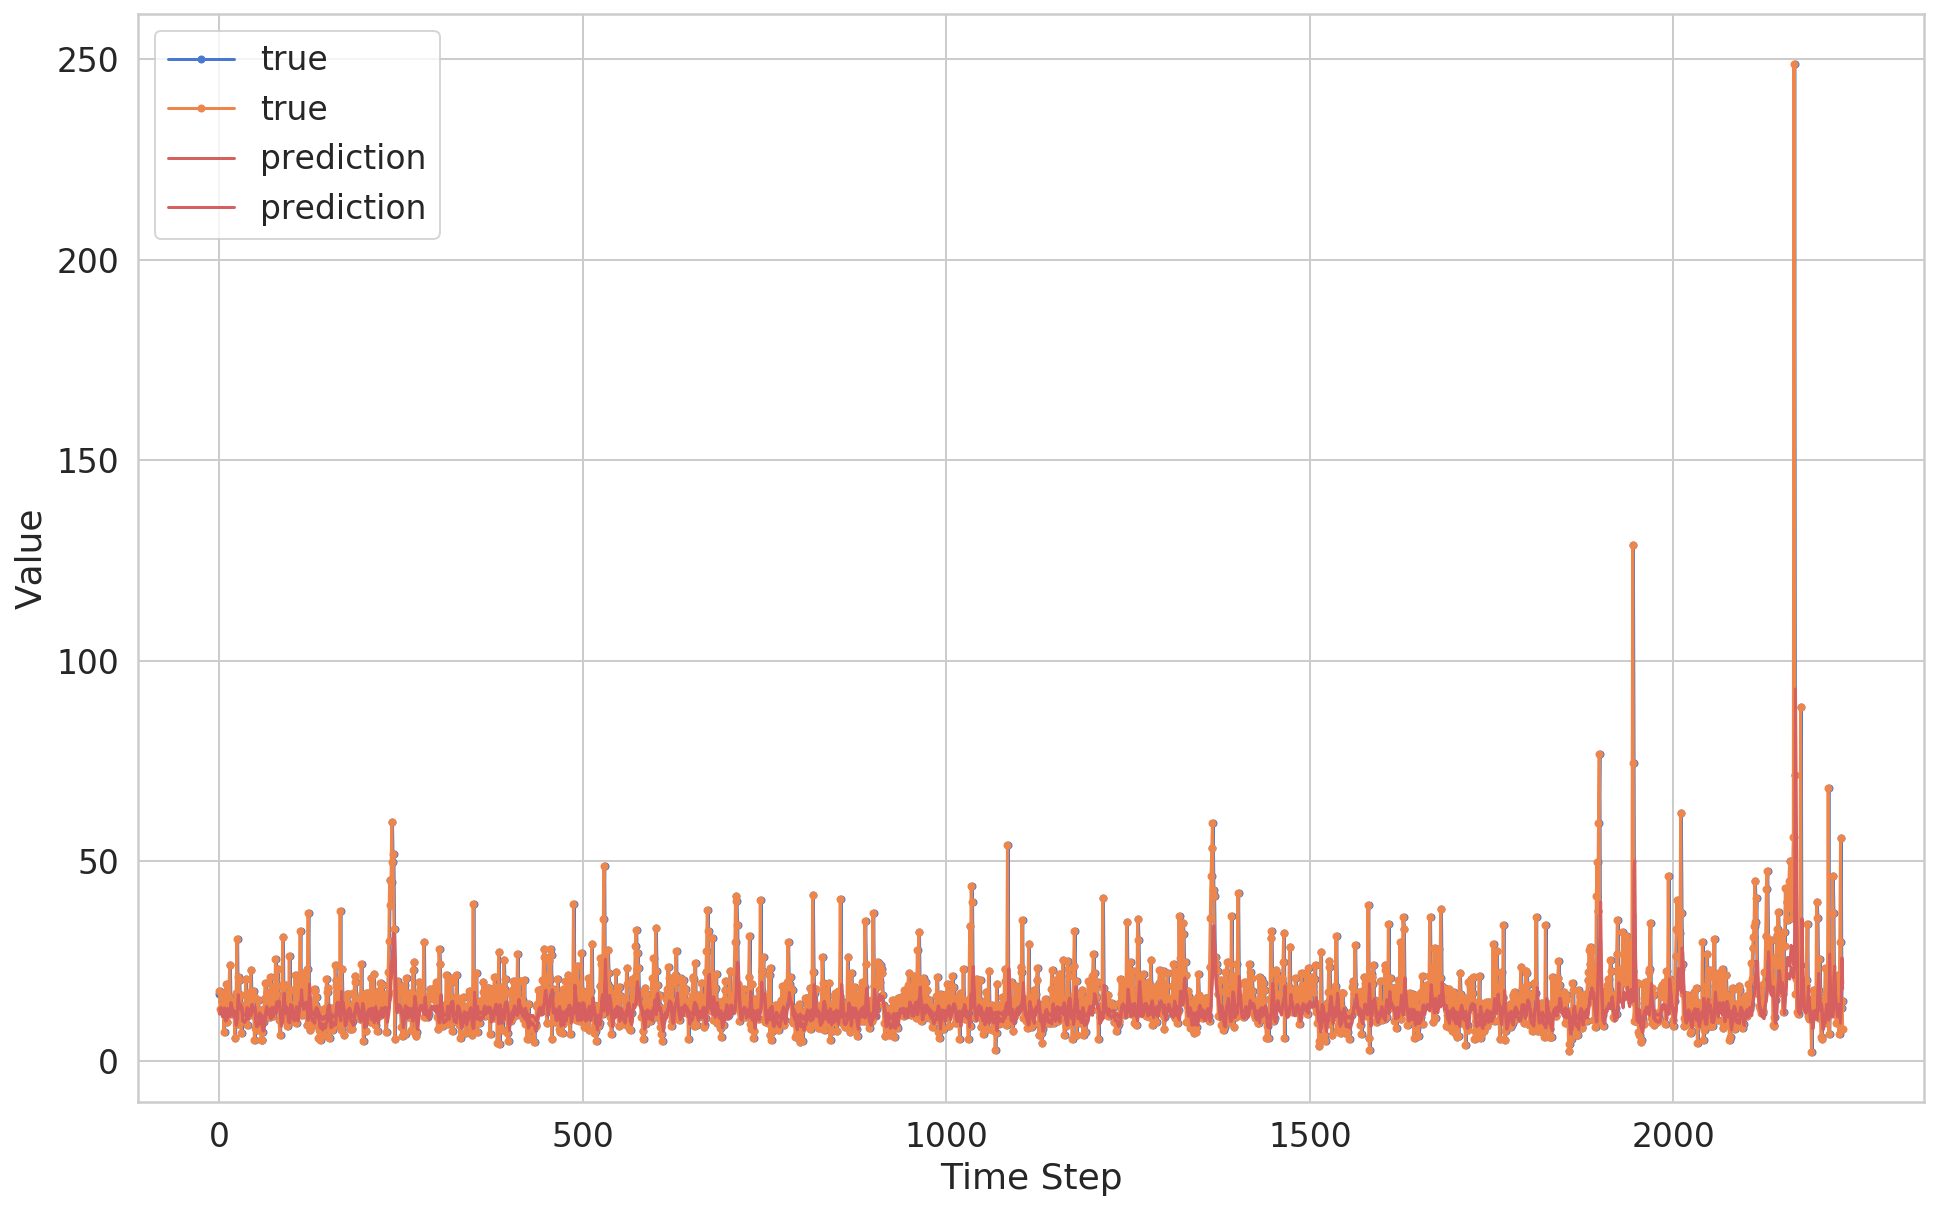

In [36]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Save and Load Model

In [17]:
scores = model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("model.h5")

print(scores)
model.summary()

346.4857897146489
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50

In [18]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')

# summarize model.
# model.summary()

# load dataset
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)

346.4857897146489


In [36]:
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D

# split a univariate dataset into train/test sets


def split_dataset(data):
    # split into standard weeks
    train_size = int(len(data) * 0.8)
    train, test = data[1:-train_size], data[-train_size:-6]
    # restructure into windows of weekly data
    return train, test

# evaluate one or more weekly forecasts against expected values


def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores


def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs


def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model


def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape(
        (train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(
        1, 3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs,
              batch_size=batch_size, verbose=verbose)
    return model

# make a forecast


def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model


def evaluate_model(train, test, n_steps, n_length, n_input):
    # fit model
    model = build_model(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores


In [38]:
# load the new file
dataset = np.array(ntrain)
# split into train and test
train, test = split_dataset(dataset)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()


IndexError: tuple index out of range

In [34]:
ntrain = train[TRAFFIC_DIRECTION]
ntrain.values

array([0.03097645, 0.0668616 , 0.06432844, ..., 0.01402057, 0.04010614,
       0.06013412])

In [35]:
# split into standard weeks
data = ntrain
train_size = int(len(data) * 0.8)
train, test = data[1:-train_size], data[-train_size:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/5))
test = array(split(test, len(test)/5))
return train, test

ValueError: array split does not result in an equal division